In [3]:
# DNN regressor
%reset
import numpy as np
import os
import tensorflow as tf
from datetime import datetime
tf.logging.set_verbosity(tf.logging.ERROR)

import matplotlib.pyplot as plt
import time
%matplotlib inline
st = time.time()

# data is assumed to be [V_vec I_vec C_vec]
# number of input_param is variable and is determined by the code
prediction_frames = []

# change the file name if using a different system
data = np.loadtxt(os.path.expanduser('~/quantum-ml/data/var_K_I_V_1000_3_10meV.txt'))

# data randomly permuted to improve learning rate
K_vec = np.linspace(3e-3,10e-3,1000)
#data = np.concatenate((K_vec.reshape(len(K_vec),1),data),axis=1)
print(data.shape)
data = np.random.permutation(data)
n_tot = data.shape[0]
n_train = int(0.9*n_tot)
n_test = n_tot - n_train

# input parameters
n_inp = int((data.shape[1])/3)
n_out = int((data.shape[1])/3)
print("Number of inputs:", n_inp)
print("Number of outputs:", n_out)


x_test_data = data[n_train:,n_inp:2*n_inp].reshape((n_test,n_inp))
y_test_data = data[n_train:,2*n_inp:].reshape((n_test,n_out)).astype(int)

print("Total, Training, Test")
print(n_tot, n_train, n_test)


#get data
def get_train_inputs():
    train_data = np.random.permutation(data[:n_train])
    x_train_data = train_data[:n_train,n_inp:2*n_inp].reshape((n_train,n_inp))
    y_train_data = train_data[:n_train,2*n_inp:].reshape((n_train,n_out)).astype(int)
    x = tf.constant(x_train_data)
    y = tf.constant(y_train_data)
    return x,y

def get_test_inputs():
    x = tf.constant(x_test_data)
    y = tf.constant(y_test_data)
    return x,y

# load datasets
features = [tf.contrib.layers.real_valued_column("",dimension=n_inp)]
regressor = tf.contrib.learn.DNNRegressor(feature_columns=features,label_dimension=n_out,hidden_units=[50,24,6])
regressor.fit(input_fn=get_train_inputs, steps=10)
# Magic happens here!
for i in range(40):
    prediction_frames += [list(regressor.predict(input_fn=get_test_inputs))]
    regressor.fit(input_fn=get_train_inputs, steps=500)
    
    
accuracy_score = regressor.evaluate(input_fn=get_test_inputs,steps=1)
print(accuracy_score)

predictions = list(regressor.predict(input_fn=get_test_inputs))


print("Completed in",time.time()-st, "seconds.")

def eval_accur(y1,y2):
    diff = np.abs(y1-y2)
    return len(np.where(diff == 0)[0])*1.0/len(diff)
accur = [eval_accur(x,y) for (x,y) in zip(y_test_data[:],np.rint(predictions))]
print("Accuracy : ",np.mean(accur))

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
(1000, 300)
Number of inputs: 100
Number of outputs: 100
Total, Training, Test
1000 900 100
{'loss': 0.075427182, 'global_step': 20010}
Completed in 340.927365064621 seconds.
Accuracy :  0.9507


In [40]:
accur = [eval_accur(x,y) for (x,y) in zip(y_test_data[:],np.rint(predictions))]
print("Accuracy : ",np.mean(accur))

Accuracy :  0.928


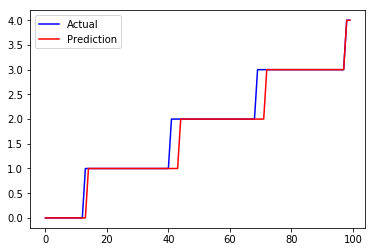

In [34]:
i = 56
plt.plot(y_test_data[i,:],'b')
plt.plot(np.rint(predictions[i][:]),'r')
plt.legend(('Actual','Prediction'))

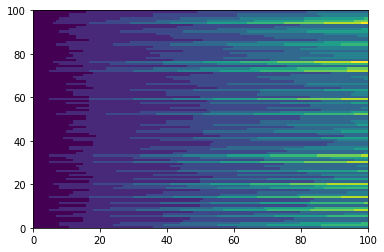

In [41]:
plt.pcolor(y_test_data)

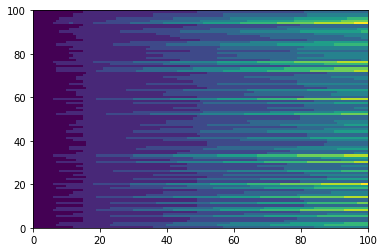

In [42]:
plt.pcolor(np.rint(predictions))

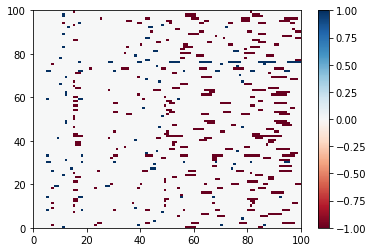

In [43]:
diff = y_test_data- np.rint(predictions)
plt.pcolor(diff,cmap='RdBu')
plt.colorbar()

In [44]:
len(prediction_frames)

15

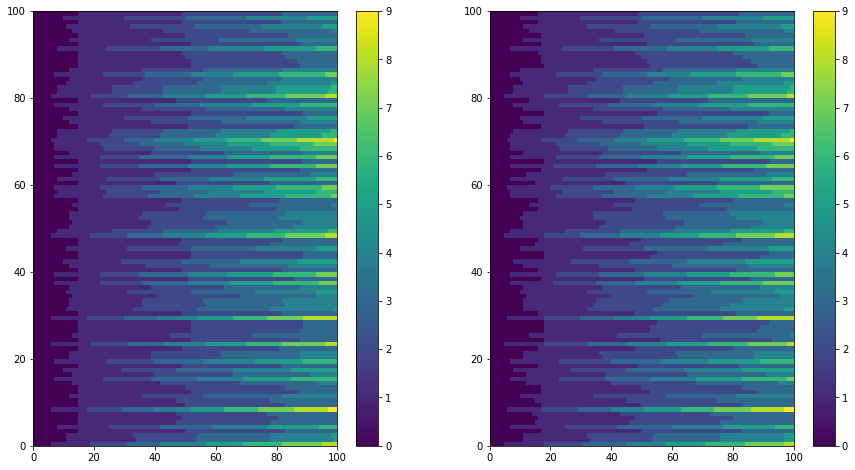

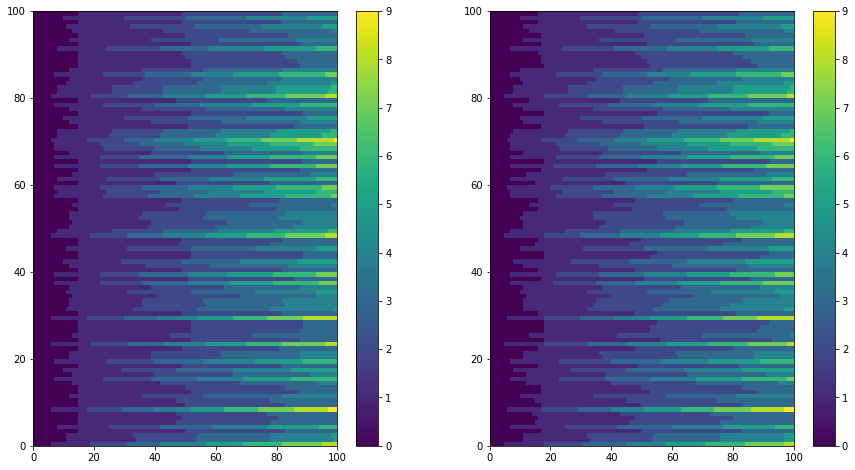

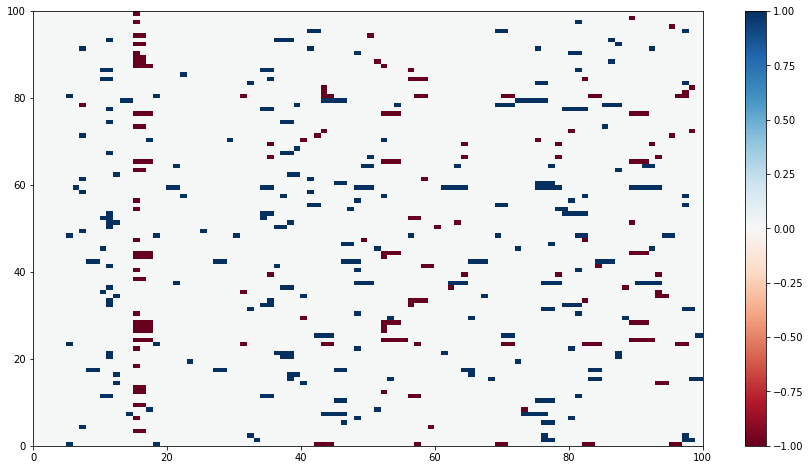

In [12]:
from IPython import display
%matplotlib inline
fig_size = [0,0]
fig_size[0] = 15
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

prediction_frames = np.rint(prediction_frames)
plt.subplot(1,2,2)
plt.pcolor(y_test_data,vmin=0,vmax=9)
plt.colorbar()
plt.subplot(1,2,1)
plt.pcolor(prediction_frames[0],vmin=0,vmax=9)
plt.colorbar()
for i in range(len(prediction_frames)):
    plt.subplot(1,2,1)
    plt.pcolor(prediction_frames[i],vmin = 0,vmax=9)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.1)

plt.figure(2)
diff = y_test_data- np.rint(predictions)
plt.pcolor(diff,cmap='RdBu')
plt.colorbar()

In [31]:
# animation
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
plt.rcParams['animation.ffmpeg_path'] ='/usr/local/bin/ffmpeg'
%matplotlib 

fig, ax = plt.subplots(1,2)
XX,YY = np.meshgrid(np.linspace(250e-3,300e-3,n_inp),np.arange(100))

def animate(i):
    line = ax[0].pcolor(XX,YY,prediction_frames[i],vmin=0,vmax=9)
    ax[0].set_title(r'Predicted $n_{iter} = $' + str(i*500))
    return line,


# Init only required for blitting to give a clean slate.
def init():
    line = ax[0].pcolor(XX,YY,prediction_frames[0],vmin=0,vmax=9)
    cbar_0 = plt.colorbar(line,ax=ax[0])
    ax[0].set_xlabel(r'$V_{dot} (V)$',fontsize=16)
    ax[0].set_ylabel('Sample Index',fontsize=16)
    ax[0].set_title(r'Expected $n_{iter} = $' + str(0))
    ax[0].set_title('Predicted')
    cbar_0.set_label('Charge State')
    
    
    line2 = ax[1].pcolor(XX,YY,y_test_data)
    cbar_1 = plt.colorbar(line2,ax=ax[1],cmap=my_cmap,ticks=[0,1,2,3])
    cbar_1.set_ticklabels(["QPC","SingleDot","DoubleDot","ShortCircuit"])
    cbar_1.set_ticks([0.5,1.5,2.5,3.5])
    ax[1].set_xlabel(r'$V_{dot} (V)$',fontsize=16)
    ax[1].set_ylabel('Sample Index',fontsize=16)  
    ax[1].set_title('Expected')
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(40) , init_func=init,
                              interval=500, blit=True)

mywriter = animation.FFMpegWriter()
ani.save('mymovie.mp4',writer=mywriter)

plt.show()

Using matplotlib backend: MacOSX


In [8]:
plt.show()

In [34]:
data = np.loadtxt(os.path.expanduser('~/quantum-ml/data/var_K_I_V_1000_3_10meV.txt'))
y_data = data[2*n_inp:].reshape((-1,n_out)).astype(int)
plt.pcolor(y_data)
%matplotlib inline